In [28]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../classifier")
from data import DataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import utils
import numpy as np

In [55]:
batch_size = 20
PREDNET_FEATURES_PER_VIDEO = 5
    
training_data_dir = './results/prednet_kitti_finetuned_moments__representation__10c/training'
train_generator = DataGenerator(batch_size=batch_size,
                                classes=['running', 'walking'],
                                max_per_class=PREDNET_FEATURES_PER_VIDEO * 100)
train_generator = train_generator.flow_from_directory(training_data_dir)
train_iterator = iter(train_generator)

test_generator = DataGenerator(batch_size=batch_size,
                                classes=['running', 'walking'],
                                index_start=PREDNET_FEATURES_PER_VIDEO * 100,
                                max_per_class=PREDNET_FEATURES_PER_VIDEO * 100)
test_generator = test_generator.flow_from_directory(training_data_dir)
test_iterator = iter(test_generator)

Found 1000 samples belonging to 2 classes in ./results/prednet_kitti_finetuned_moments__representation__10c/training
No data found in ./results/prednet_kitti_finetuned_moments__representation__10c/training!
Found 967 samples belonging to 2 classes in ./results/prednet_kitti_finetuned_moments__representation__10c/training
Total sources used: 195
Data shape: (16, 20, 339)


In [52]:
X, y = next(train_iterator)
print(X.shape, y.shape)

((20, 16, 20, 339), (20, 3))


In [54]:
x = [[ 1. , 0.],[ 1.,  1.],[ 1.,  2.],[ 1.,  3.],
     [ 1.,  4.],[ 1.,  5.],[ 1.,  6.],[ 1.,  7.]]
x = np.array(x)

print(y)
print(x.reshape((2, 8) + x.shape[2:]))
#y, (5, 8) + y.shape[2:]

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]
[[ 1.  0.  1.  1.  1.  2.  1.  3.]
 [ 1.  4.  1.  5.  1.  6.  1.  7.]]


In [17]:
from sklearn.decomposition import PCA

train_X = []
train_y = []
for i in range(len(train_generator)):
    X, y = next(train_iterator)
    train_X.append(X.flatten())
    train_y.append(np.argmax(y[0]))

print(len(train_X), len(train_y))
#pca = PCA(n_components=100).fit(train_X)
#train_X = pca.transform(train_X)
train_X[0].shape, train_y[0]

(1000, 1000)


((108480,), 0)

In [21]:
test_X = []
test_y = []
for i in range(len(test_generator)):
    X, y = next(test_iterator)
    test_X.append(X.flatten())
    test_y.append(np.argmax(y[0]))
    
print(len(test_X), len(test_y))
#test_X = pca.transform(test_X)
test_X[0].shape, test_y[0]

(967, 967)


((108480,), 0)

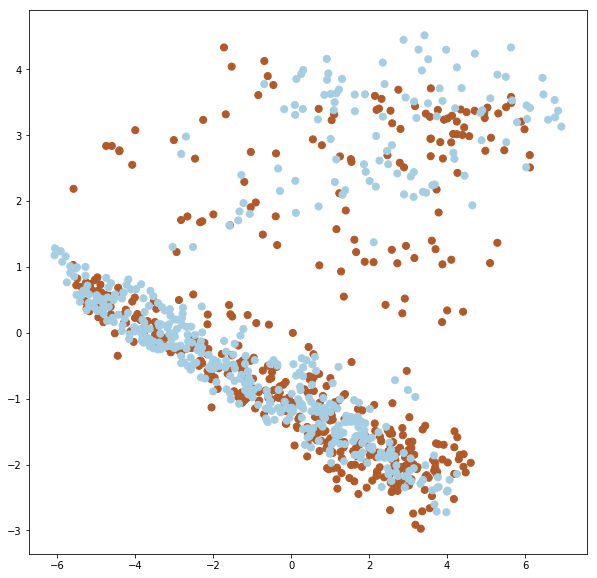

In [23]:
plt.figure(figsize=(10, 10))
X_pca = PCA(n_components=2).fit_transform(test_X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_y, s=50, cmap=plt.cm.Paired)

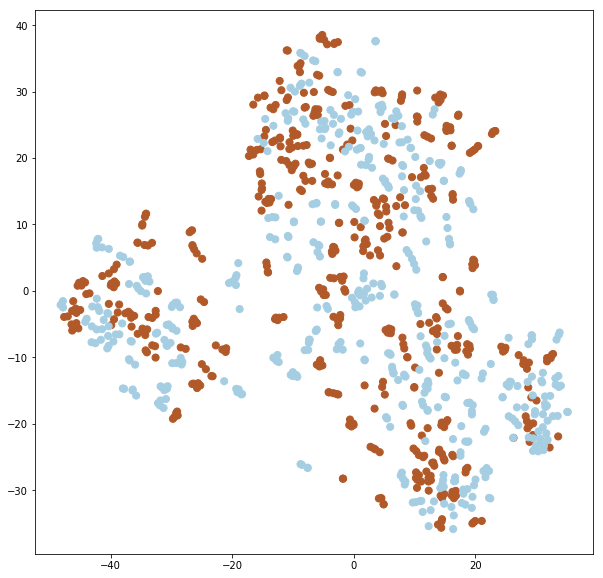

In [24]:
from sklearn.manifold import TSNE

#X_tsne = TSNE(random_state=17, n_iter=2000, perplexity=47).fit_transform(test_X)

plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.array(test_y), s=50, cmap=plt.cm.Paired)

In [20]:
#from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(train_X, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [ ]:
preds = svm.predict(test_X)
#print(test_y, preds)
accuracy_score(test_y, preds)

In [11]:
%reload_ext autoreload
%autoreload 2
import prednet_model
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, Conv3D, LSTM, TimeDistributed
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Input, Average, Masking, Reshape, Concatenate, Lambda, Bidirectional
import numpy as np

def crop(dimension, start=None, end=None, stride=1, name=None):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    # See https://github.com/keras-team/keras/issues/890
    def func(x):
        if dimension == 0:
            return x[start:end:stride]
        if dimension == 1:
            return x[:, start:end:stride]
        if dimension == 2:
            return x[:, :, start:end:stride]
        if dimension == 3:
            return x[:, :, :, start:end:stride]
        if dimension == 4:
            return x[:, :, :, :, start:end:stride]
    return Lambda(func, name=name)

def conv_layer(tensor, filters, dropout, data_format, name):
    x = tensor
    for i, f in enumerate(filters):
        name_ = name + '_' + str(i)
        x = TimeDistributed(Conv2D(f, (3, 3), padding='same', 
                                   data_format=data_format, 
                                   activation='relu'), 
                            name='conv_' + name_)(x)
        #x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), 
                                         data_format=data_format, 
                                         padding='same'), 
                            name='maxpool_' + name_)(x)
        x = TimeDistributed(Dropout(dropout), name='dropout_' + name_)(x)
    return x

def lstm_layer(tensor, mask_value, hidden_dims, dropout, name):
    x = TimeDistributed(Flatten(), name='flatten_' + name)(tensor)
    if mask_value is not None:
        x = Masking(mask_value=mask_value)(x)
    for dim in hidden_dims:
        x = Bidirectional(LSTM(dim, return_sequences=False, dropout=dropout), 
                          merge_mode='concat', name='BiLSTM_' + name)(x)
    return x

def multistream(input_shape, n_classes, hidden_dims, 
                drop_rate=0.5, mask_value=None, **config):
    if config is None:
        config = {}
    config['input_width'] = input_shape[1]
    config['input_height'] = input_shape[2]
    config['input_channels'] = input_shape[3]
    
    model = prednet_model.create_model(train=False, 
                                       output_mode='representation', 
                                       **config)
    prednet_layer = model.layers[1]
    prednet_layer.trainable = False
    
    layer_config = prednet_layer.get_config()
    data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
    
    image = model.inputs[0]
    conv_filters = [50, 50, 10]
    image = conv_layer(image, conv_filters, drop_rate, data_format, 'image')
    image = lstm_layer(image, mask_value, hidden_dims, drop_rate, 'image')
    
    index = 0
    reps = []
    flat_shapes = [61440, 245760, 122880, 61440]
    filters = [3, 48, 96, 192]
    prednet_out = crop(1, stride=10, name='timestep_crop')(model.outputs[0])
    prednet_out = crop(1, stride=-1, name='invert')(prednet_out)
    
    for l in range(prednet_layer.nb_layers):
        if l not in [1, 2]:
            r = crop(2, index, index + flat_shapes[l], 
                     name='r_crop_' + str(l))(prednet_out)
            # Unflatten representation
            width = input_shape[1] / (2 ** l)
            height = input_shape[2] / (2 ** l)
            
            if data_format == 'channels_first':
                shape = (-1, filters[l], height, width)
            else:
                shape = (-1, height, width, filters[l])
                
            r = Reshape(shape)(r)
            reps.append(r)
        index += flat_shapes[l]
        
    rep_layers = []
    conv_filters = [[50, 50, 10], [50]]
    for i, r in enumerate(reps):
        rep_l = conv_layer(r, conv_filters[i], drop_rate, data_format, 'r' + str(i))
        rep_l = lstm_layer(rep_l, mask_value, hidden_dims, drop_rate, 'r' + str(i))
        rep_layers.append(rep_l)
        
    x = Concatenate(axis=1)([image] + [l for l in rep_layers])
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=model.inputs, outputs=predictions)
    return model

config = {
    #'batch_size': 5,
    'seq_length': 10,
    'n_timesteps': 10,
    #'data_format': 'channels_first',
    'model_weights_file': './results/prednet_kitti__moments__model__full/weights.hdf5',
    'model_json_file': './results/prednet_kitti__moments__model__full/model.json'
}
multistream([10, 160, 128, 3], 2, [256], **config).summary()

Loading model: ./results/prednet_kitti__moments__model__full/weights.hdf5
Layer 0 shape: (3, 128, 160) (61440)
Layer 1 shape: (48, 64, 80) (245760)
Layer 2 shape: (96, 32, 40) (122880)
Layer 3 shape: (192, 16, 20) (61440)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 10, 3, 128, 1 0                                            
__________________________________________________________________________________________________
prednet_1 (PredNet)             (None, 10, 491520)   6915948     input_8[0][0]                    
__________________________________________________________________________________________________
timestep_crop (Lambda)          (None, 1, 491520)    0           prednet_1[0][0]                  
_____________________________________________________________________________________

In [6]:
print([i for i in range(10)])
print([i for i in range(10)][None:None:-10][None:None:-1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[9]
